@misc{chollet2015keras,
  title={Keras},
  author={Chollet, Fran\c{c}ois and others},
  year={2015},
  howpublished={\url{https://keras.io}},
}

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

Define the path

In [2]:
path2data = os.path.join(os.getcwd(), "dataset", "train_data")
print(path2data)

h:\Approach2_sol\dataset\train_data


Split the data (80% train, 20% Validation) and resizing the images

In [3]:
image_size = (64, 64)
batch_size = 32

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    path2data,
    validation_split=0.20,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 1425 files belonging to 6 classes.
Using 1140 files for training.
Using 285 files for validation.


Visualize the data

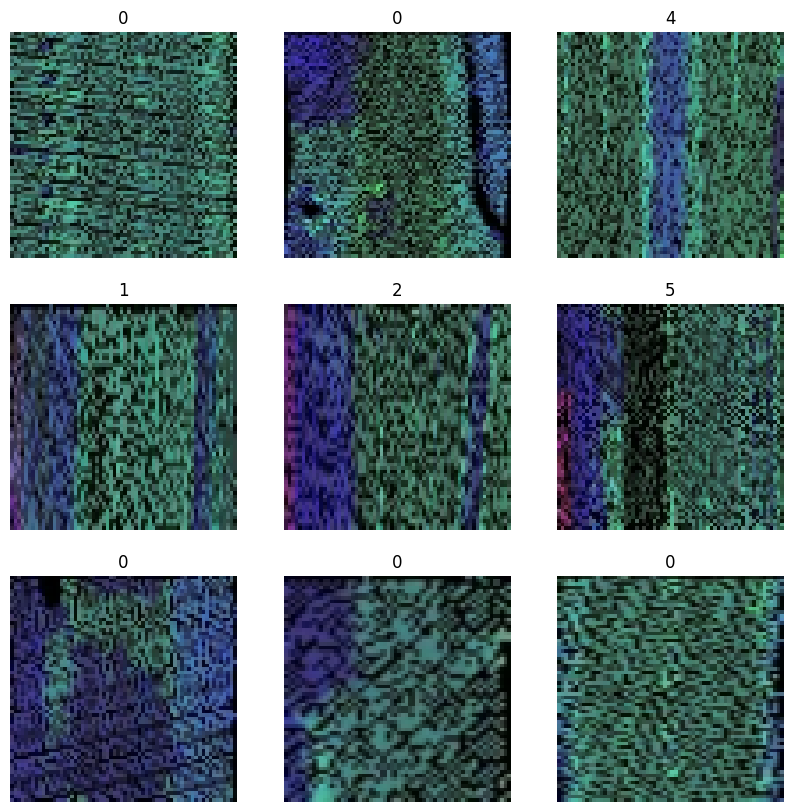

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Data augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
    ]
)

Visualize the augmented data

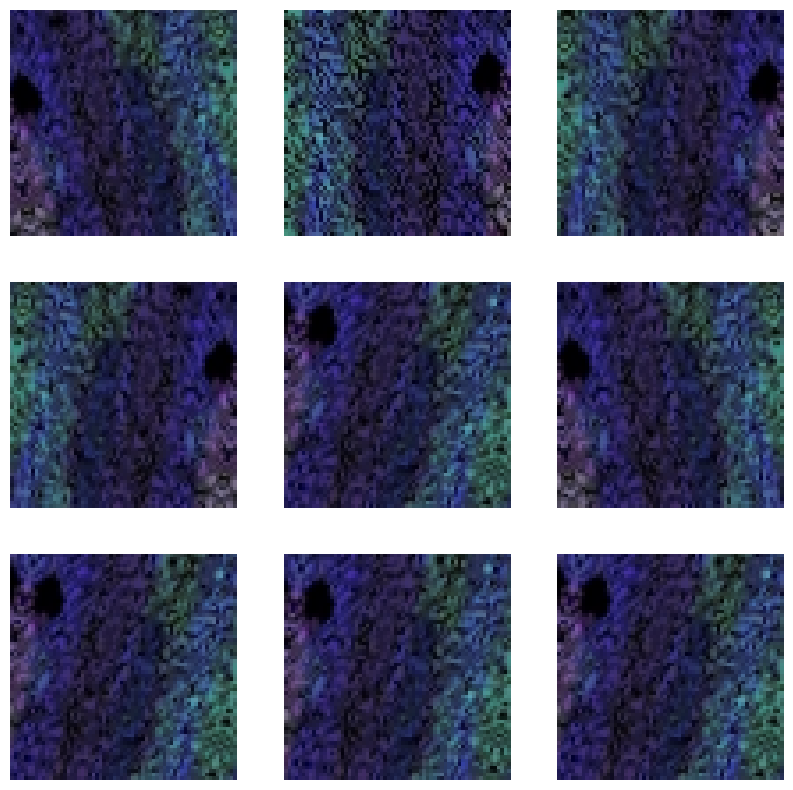

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

The model

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=6)
#keras.utils.plot_model(model, show_shapes=True)

Running the code

In [10]:
epochs = 60
num_classes=6

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

def preprocess_data(image, label):
    image = data_augmentation(image)  # Apply data augmentation
    label = tf.one_hot(label, depth=num_classes)  # Convert label to one-hot encoded using TensorFlow operation
    return image, label

train_ds = train_ds.map(lambda x, y: preprocess_data(x, y))
val_ds = val_ds.map(lambda x, y: preprocess_data(x, y))


model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

evaluation = model.evaluate(train_ds)
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

Epoch 1/60
36/36 [==============================] - 37s 924ms/step - loss: 1.5657 - accuracy: 0.4000 - val_loss: 1.8111 - val_accuracy: 0.0877
Epoch 2/60
36/36 [==============================] - 32s 892ms/step - loss: 1.3016 - accuracy: 0.4974 - val_loss: 1.8689 - val_accuracy: 0.0877
Epoch 3/60
36/36 [==============================] - 32s 895ms/step - loss: 1.1702 - accuracy: 0.5447 - val_loss: 1.9658 - val_accuracy: 0.0877
Epoch 4/60
36/36 [==============================] - 32s 875ms/step - loss: 1.0978 - accuracy: 0.5895 - val_loss: 2.0668 - val_accuracy: 0.0877
Epoch 5/60
36/36 [==============================] - 31s 865ms/step - loss: 1.0484 - accuracy: 0.6167 - val_loss: 2.2284 - val_accuracy: 0.0877
Epoch 6/60
36/36 [==============================] - 31s 868ms/step - loss: 1.0547 - accuracy: 0.5851 - val_loss: 2.2449 - val_accuracy: 0.0877
Epoch 7/60
36/36 [==============================] - 31s 858ms/step - loss: 1.0242 - accuracy: 0.6123 - val_loss: 2.4615 - val_accuracy: 0.0877

In [11]:
evaluation = model.evaluate(val_ds)
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

9/9 [==============================] - 2s 176ms/step - loss: 1.1475 - accuracy: 0.6596
Validation Loss: 1.1474940776824951
Validation Accuracy: 0.659649133682251
